In [1]:
import sys,os
__script_path=os.path.abspath(globals().get('__file__','.'))
__script_dir = os.path.dirname(__script_path)
root_dir = os.path.abspath(f'{__script_dir}/../..')
print(root_dir)
for lib in [root_dir][::-1]:
    if lib in sys.path:
        sys.path.remove(lib)
    sys.path.insert(0,lib)

from libs.lib import *

d:\ads_test


In [2]:
# wandb.init(project="ads_nckh_fraud_detection")


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dinhtanloc (nckh_ueh). Use `wandb login --relogin` to force relogin


In [3]:
import tensorflow as tf
print(tf.__version__)

2.13.0


In [4]:
exps_dir = "../../../exps"
# exps_dir = sys.argv[3]

if os.path.exists(exps_dir) == False: # tạo thư mục (nếu chưa có)
  os.makedirs(exps_dir, exist_ok=True)

save_dir = f"{exps_dir}/feature1"
os.makedirs(save_dir, exist_ok=True)
test_size=0.33
seed=42

* kiểm tra và tạo các thư mục (nếu chưa có)
* tập test 33%

# 5. Xây dựng và đánh giá mô hình học sâu Neutual Network

In [5]:
dict_data=[]
y_list = []
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Dữ liệu label đã được mã hóa
def oneHot(arr):
    labels = np.array(arr)
    
    # Khởi tạo một trình chuyển đổi OneHotEncoder
    encoder = OneHotEncoder(sparse=False)
    
    # Reshape lại dữ liệu labels để có dạng cột (cần là ma trận 2D)
    labels_reshaped = labels.reshape(-1, 1)
    
    # Fit trình chuyển đổi vào dữ liệu
    encoder.fit(labels_reshaped)
    
    # Chuyển đổi labels sang dạng one-hot encoding
    onehot_labels = encoder.transform(labels_reshaped)
    return onehot_labels
for scaler in ['Standard_Label','MinMax_Label']:
    for type in ['basic','class_dict_weight','Oversampling','SMOTE','Undersampling']:
        x_train = pd.read_excel(f'{exps_dir}/{scaler}/{type}/feature/x_train.xlsx')
        y_train = pd.read_excel(f'{exps_dir}/{scaler}/{type}/feature/y_train.xlsx')
        x_test = pd.read_excel(f'{exps_dir}/{scaler}/{type}/feature/x_test.xlsx')
        y_test = pd.read_excel(f'{exps_dir}/{scaler}/{type}/feature/y_test.xlsx')
        y_list.append(y_test)
        y_train=oneHot(y_train)
        y_test=oneHot(y_test)
        print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)
        dict_data.append((x_train,y_train,x_test,y_test))

class_weights_dict=dict(np.load(f'{exps_dir}/Standard_Label/class_dict_weight/feature/class_weights_dict.npz',allow_pickle=True))['class_weights_dict']
class_weights_dict = {key: value for key, value in class_weights_dict.item().items()}
class_weights_dict
print(len(dict_data))

(656, 42) (656, 2) (324, 42) (324, 2)
(656, 42) (656, 2) (324, 42) (324, 2)
(1001, 42) (1001, 2) (324, 42) (324, 2)
(1002, 42) (1002, 2) (324, 42) (324, 2)
(355, 42) (355, 2) (324, 42) (324, 2)
(656, 42) (656, 2) (324, 42) (324, 2)
(656, 42) (656, 2) (324, 42) (324, 2)
(1001, 42) (1001, 2) (324, 42) (324, 2)
(1002, 42) (1002, 2) (324, 42) (324, 2)
(355, 42) (355, 2) (324, 42) (324, 2)
10


In [6]:
x_train=pd.read_excel(f'{save_dir}/x_train.xlsx')
y_train=pd.read_excel(f'{save_dir}/y_train.xlsx')
x_test=pd.read_excel(f'{save_dir}/x_test.xlsx')
y_test=pd.read_excel(f'{save_dir}/y_test.xlsx')
class_weights_dict=dict(np.load(f'{exps_dir}/feature1/class_weights_dict.npz',allow_pickle=True))['class_weights_dict']
class_weights_dict = {key: value for key, value in class_weights_dict.item().items()}
class_weights_dict

{0: 1.0, 1: 1.0}

In [7]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Dữ liệu label đã được mã hóa
def oneHot(arr):
    labels = np.array(arr)
    # Khởi tạo một trình chuyển đổi OneHotEncoder
    encoder = OneHotEncoder(sparse=False)
    
    # Reshape lại dữ liệu labels để có dạng cột (cần là ma trận 2D)
    labels_reshaped = labels.reshape(-1, 1)
    
    # Fit trình chuyển đổi vào dữ liệu
    encoder.fit(labels_reshaped)
    
    # Chuyển đổi labels sang dạng one-hot encoding
    onehot_labels = encoder.transform(labels_reshaped)
    return onehot_labels

y_train_onehot=oneHot(y_train)
y_test_onehot=oneHot(y_test)

In [8]:
x_test.shape

(330, 42)

In [9]:
x_train.shape

(1022, 42)

#### * Xây dựng model:

In [10]:
#from tensorflow.keras.utils import to_categorical
#y_train = to_categorical(y_train, num_classes=2)
#y_test = to_categorical(y_test, num_classes=2)
#y_train

In [11]:
from sklearn.metrics import f1_score
import tensorflow as tf
def f1_loss(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 1), tf.equal(y_pred, 1)), tf.float32))
    predicted_positives = tf.reduce_sum(tf.cast(y_pred, tf.float32))
    possible_positives = tf.reduce_sum(tf.cast(y_true, tf.float32))
    
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    
    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    return 1 - f1

In [12]:
def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
    pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
    loss = -tf.reduce_mean(alpha * tf.pow(1.0 - pt, gamma) * tf.math.log(pt))
    return loss


In [13]:
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=-1)
    denominator = tf.reduce_sum(y_true + y_pred, axis=-1)
    return 1 - (numerator + 1) / (denominator + 1)


In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_coef_loss(y_true, y_pred, smooth=0.0001):
    return 1 - dice_coef(y_true, y_pred, smooth)

In [15]:
from keras import backend as K

def f1_score(y_true, y_pred):
    """
    F1 score metric.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    
    f1_score = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_score

In [16]:
from tensorflow.keras.optimizers.legacy import Adam
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, Dense, Flatten
from keras.models import Model
from keras.layers import Input
import tensorflow as tf
input_shape =(42,1)
x_input = Input(shape=input_shape)
dense_units = 1024
learning_rate = 0.0001
kernel_size =3
filter_size=128


# Block 1
x = Conv1D(filter_size, kernel_size, activation='relu', padding='same', name='block1_conv1')(x_input)
x = Conv1D(filter_size, kernel_size, activation='relu', padding='same', name='block1_conv2')(x)
x = MaxPooling1D(2, strides=2, name='block1_pool')(x)

# Block 2
x = Conv1D(filter_size*2, kernel_size, activation='relu', padding='same', name='block2_conv1')(x)
x = Conv1D(filter_size*2, kernel_size, activation='relu', padding='same', name='block2_conv2')(x)
x = MaxPooling1D(2, strides=2, name='block2_pool')(x)

# Block 3
x = Conv1D(filter_size*4, kernel_size, activation='relu', padding='same', name='block3_conv1')(x)
x = Conv1D(filter_size*4, kernel_size, activation='relu', padding='same', name='block3_conv2')(x)
x = Conv1D(filter_size*4, kernel_size, activation='relu', padding='same', name='block3_conv3')(x)
x = MaxPooling1D(2, strides=2, name='block3_pool')(x)

# Block 4
x = Conv1D(filter_size*8, kernel_size, activation='relu', padding='same', name='block4_conv1')(x)
x = Conv1D(filter_size*8, kernel_size, activation='relu', padding='same', name='block4_conv2')(x)
x = Conv1D(filter_size*8, kernel_size, activation='relu', padding='same', name='block4_conv3')(x)
x = MaxPooling1D(2, strides=2, name='block4_pool')(x)

# Block 5
x = Conv1D(filter_size*8, kernel_size, activation='relu', padding='same', name='block5_conv1')(x)
x = Conv1D(filter_size*8, kernel_size, activation='relu', padding='same', name='block5_conv2')(x)
x = Conv1D(filter_size*8, kernel_size, activation='relu', padding='same', name='block5_conv3')(x)
x = MaxPooling1D(2, strides=2, name='block5_pool')(x)

# x = Flatten(name='flatten')(x)
# x = Dense(dense_units, activation='relu', name='fc1')(x)
# x = Dense(dense_units, activation='relu', name='fc2')(x)
# x = Dense(1, activation='sigmoid', name='predictions')(x)  # Sigmoid for binary classification

x = GlobalAveragePooling1D()(x)
# x = GlobalMaxPooling1D()(x)
x = Dense(2, activation='softmax', name='predictions')(x)  # Sigmoid for binary classification

# Create model.
model = Model(x_input, x, name='vgg16')
# model.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy',f1_score])
# model.compile(optimizer=Adam(lr=learning_rate), loss=f1_loss, metrics=['accuracy',f1_score])
# model.compile(optimizer=Adam(lr=learning_rate), loss=focal_loss, metrics=['accuracy',f1_score])
model.compile(optimizer=Adam(lr=learning_rate), loss=dice_coef_loss, metrics=['accuracy',f1_score])
early_stopping = EarlyStopping(monitor='val_accuracy',
    # min_delta=0.00005,
    patience=60,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.95,
    patience=10,
    min_lr=0.000001,
    verbose=1,
)


In [17]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 42, 1)]           0         
                                                                 
 block1_conv1 (Conv1D)       (None, 42, 128)           512       
                                                                 
 block1_conv2 (Conv1D)       (None, 42, 128)           49280     
                                                                 
 block1_pool (MaxPooling1D)  (None, 21, 128)           0         
                                                                 
 block2_conv1 (Conv1D)       (None, 21, 256)           98560     
                                                                 
 block2_conv2 (Conv1D)       (None, 21, 256)           196864    
                                                                 
 block2_pool (MaxPooling1D)  (None, 10, 256)           0     

In [18]:
#Set data order
data_order = 8

In [19]:
model.fit(x=dict_data[data_order][0],y=dict_data[data_order][1],
          validation_data=(dict_data[data_order][2],dict_data[data_order][3]),
          batch_size=64,epochs= 10000, callbacks=[wandb.keras.WandbCallback(),early_stopping,lr_scheduler])

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/10000
16/16 [==============================] - ETA: 0s - loss: 0.4999 - accuracy: 0.5000 - f1_score: 0.4990INFO:tensorflow:Assets written to: d:\ads_test\prj\4.model\VGG16\wandb\run-20240321_230556-cpaygl9l\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ads_test\prj\4.model\VGG16\wandb\run-20240321_230556-cpaygl9l\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj\4.model\VGG16\wandb\run-20240321_230556-cpaygl9l\files\model-best)... Done. 0.5s


16/16 [==============================] - 21s 1s/step - loss: 0.4999 - accuracy: 0.5000 - f1_score: 0.4990 - val_loss: 0.4580 - val_accuracy: 0.7377 - val_f1_score: 0.7396 - lr: 1.0000e-04
Epoch 2/10000
16/16 [==============================] - ETA: 0s - loss: 0.4871 - accuracy: 0.5000 - f1_score: 0.4985INFO:tensorflow:Assets written to: d:\ads_test\prj\4.model\VGG16\wandb\run-20240321_230556-cpaygl9l\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ads_test\prj\4.model\VGG16\wandb\run-20240321_230556-cpaygl9l\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj\4.model\VGG16\wandb\run-20240321_230556-cpaygl9l\files\model-best)... Done. 0.5s


16/16 [==============================] - 21s 1s/step - loss: 0.4871 - accuracy: 0.5000 - f1_score: 0.4985 - val_loss: 0.3204 - val_accuracy: 0.7377 - val_f1_score: 0.7396 - lr: 1.0000e-04
Epoch 3/10000
16/16 [==============================] - 17s 1s/step - loss: 0.4042 - accuracy: 0.6188 - f1_score: 0.6177 - val_loss: 0.3548 - val_accuracy: 0.6420 - val_f1_score: 0.6979 - lr: 1.0000e-04
Epoch 4/10000
16/16 [==============================] - ETA: 0s - loss: 0.2995 - accuracy: 0.7026 - f1_score: 0.7044INFO:tensorflow:Assets written to: d:\ads_test\prj\4.model\VGG16\wandb\run-20240321_230556-cpaygl9l\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ads_test\prj\4.model\VGG16\wandb\run-20240321_230556-cpaygl9l\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj\4.model\VGG16\wandb\run-20240321_230556-cpaygl9l\files\model-best)... Done. 0.5s


16/16 [==============================] - 20s 1s/step - loss: 0.2995 - accuracy: 0.7026 - f1_score: 0.7044 - val_loss: 0.3012 - val_accuracy: 0.6975 - val_f1_score: 0.7057 - lr: 1.0000e-04
Epoch 5/10000
16/16 [==============================] - 17s 1s/step - loss: 0.2784 - accuracy: 0.7265 - f1_score: 0.7201 - val_loss: 0.6149 - val_accuracy: 0.3796 - val_f1_score: 0.3594 - lr: 1.0000e-04
Epoch 6/10000
16/16 [==============================] - 17s 1s/step - loss: 0.3169 - accuracy: 0.6826 - f1_score: 0.6843 - val_loss: 0.3499 - val_accuracy: 0.6543 - val_f1_score: 0.7083 - lr: 1.0000e-04
Epoch 7/10000
16/16 [==============================] - ETA: 0s - loss: 0.2683 - accuracy: 0.7335 - f1_score: 0.7321INFO:tensorflow:Assets written to: d:\ads_test\prj\4.model\VGG16\wandb\run-20240321_230556-cpaygl9l\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ads_test\prj\4.model\VGG16\wandb\run-20240321_230556-cpaygl9l\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj\4.model\VGG16\wandb\run-20240321_230556-cpaygl9l\files\model-best)... Done. 0.4s


16/16 [==============================] - 20s 1s/step - loss: 0.2683 - accuracy: 0.7335 - f1_score: 0.7321 - val_loss: 0.2548 - val_accuracy: 0.7469 - val_f1_score: 0.7474 - lr: 1.0000e-04
Epoch 8/10000
16/16 [==============================] - 16s 1s/step - loss: 0.2330 - accuracy: 0.7675 - f1_score: 0.7679 - val_loss: 0.3037 - val_accuracy: 0.6975 - val_f1_score: 0.7448 - lr: 1.0000e-04
Epoch 9/10000
16/16 [==============================] - 16s 1s/step - loss: 0.2173 - accuracy: 0.7834 - f1_score: 0.7835 - val_loss: 0.2931 - val_accuracy: 0.7037 - val_f1_score: 0.7500 - lr: 1.0000e-04
Epoch 10/10000
16/16 [==============================] - ETA: 0s - loss: 0.2060 - accuracy: 0.7974 - f1_score: 0.7977INFO:tensorflow:Assets written to: d:\ads_test\prj\4.model\VGG16\wandb\run-20240321_230556-cpaygl9l\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ads_test\prj\4.model\VGG16\wandb\run-20240321_230556-cpaygl9l\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj\4.model\VGG16\wandb\run-20240321_230556-cpaygl9l\files\model-best)... Done. 0.5s


16/16 [==============================] - 20s 1s/step - loss: 0.2060 - accuracy: 0.7974 - f1_score: 0.7977 - val_loss: 0.2546 - val_accuracy: 0.7469 - val_f1_score: 0.7474 - lr: 1.0000e-04
Epoch 11/10000
16/16 [==============================] - 16s 1s/step - loss: 0.2051 - accuracy: 0.7944 - f1_score: 0.7922 - val_loss: 0.2811 - val_accuracy: 0.7191 - val_f1_score: 0.7240 - lr: 1.0000e-04
Epoch 12/10000
16/16 [==============================] - 16s 1s/step - loss: 0.2292 - accuracy: 0.7725 - f1_score: 0.7748 - val_loss: 0.2971 - val_accuracy: 0.7037 - val_f1_score: 0.7109 - lr: 1.0000e-04
Epoch 13/10000
16/16 [==============================] - 16s 981ms/step - loss: 0.1983 - accuracy: 0.8014 - f1_score: 0.8021 - val_loss: 0.3253 - val_accuracy: 0.6759 - val_f1_score: 0.7266 - lr: 1.0000e-04
Epoch 14/10000
16/16 [==============================] - 16s 979ms/step - loss: 0.1929 - accuracy: 0.8074 - f1_score: 0.8069 - val_loss: 0.3439 - val_accuracy: 0.6543 - val_f1_score: 0.7083 - lr: 1.000

INFO:tensorflow:Assets written to: d:\ads_test\prj\4.model\VGG16\wandb\run-20240321_230556-cpaygl9l\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj\4.model\VGG16\wandb\run-20240321_230556-cpaygl9l\files\model-best)... Done. 0.5s



Epoch 17: ReduceLROnPlateau reducing learning rate to 9.499999760009814e-05.
16/16 [==============================] - 19s 1s/step - loss: 0.1986 - accuracy: 0.8024 - f1_score: 0.8046 - val_loss: 0.2542 - val_accuracy: 0.7438 - val_f1_score: 0.7448 - lr: 1.0000e-04
Epoch 18/10000
16/16 [==============================] - 17s 1s/step - loss: 0.1832 - accuracy: 0.8164 - f1_score: 0.8167 - val_loss: 0.2860 - val_accuracy: 0.7130 - val_f1_score: 0.6797 - lr: 9.5000e-05
Epoch 19/10000
16/16 [==============================] - 16s 1s/step - loss: 0.1847 - accuracy: 0.8154 - f1_score: 0.8132 - val_loss: 0.2582 - val_accuracy: 0.7438 - val_f1_score: 0.7448 - lr: 9.5000e-05
Epoch 20/10000
16/16 [==============================] - 16s 984ms/step - loss: 0.2172 - accuracy: 0.7824 - f1_score: 0.7835 - val_loss: 0.3140 - val_accuracy: 0.6852 - val_f1_score: 0.7344 - lr: 9.5000e-05
Epoch 21/10000
16/16 [==============================] - 16s 997ms/step - loss: 0.1758 - accuracy: 0.8234 - f1_score: 0.823

INFO:tensorflow:Assets written to: d:\ads_test\prj\4.model\VGG16\wandb\run-20240321_230556-cpaygl9l\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj\4.model\VGG16\wandb\run-20240321_230556-cpaygl9l\files\model-best)... Done. 0.4s


16/16 [==============================] - 19s 1s/step - loss: 0.1984 - accuracy: 0.8024 - f1_score: 0.8015 - val_loss: 0.2458 - val_accuracy: 0.7531 - val_f1_score: 0.7526 - lr: 9.0250e-05
Epoch 30/10000
16/16 [==============================] - 17s 1s/step - loss: 0.1947 - accuracy: 0.8074 - f1_score: 0.8090 - val_loss: 0.2916 - val_accuracy: 0.7099 - val_f1_score: 0.6771 - lr: 9.0250e-05
Epoch 31/10000
16/16 [==============================] - 17s 1s/step - loss: 0.2864 - accuracy: 0.7146 - f1_score: 0.7130 - val_loss: 0.5670 - val_accuracy: 0.4321 - val_f1_score: 0.4427 - lr: 9.0250e-05
Epoch 32/10000
16/16 [==============================] - 16s 996ms/step - loss: 0.2638 - accuracy: 0.7365 - f1_score: 0.7366 - val_loss: 0.2971 - val_accuracy: 0.7006 - val_f1_score: 0.6693 - lr: 9.0250e-05
Epoch 33/10000
16/16 [==============================] - 16s 984ms/step - loss: 0.1996 - accuracy: 0.8024 - f1_score: 0.8041 - val_loss: 0.2630 - val_accuracy: 0.7377 - val_f1_score: 0.7786 - lr: 9.025

INFO:tensorflow:Assets written to: d:\ads_test\prj\4.model\VGG16\wandb\run-20240321_230556-cpaygl9l\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj\4.model\VGG16\wandb\run-20240321_230556-cpaygl9l\files\model-best)... Done. 0.5s


16/16 [==============================] - 19s 1s/step - loss: 0.2003 - accuracy: 0.8004 - f1_score: 0.8011 - val_loss: 0.2439 - val_accuracy: 0.7562 - val_f1_score: 0.7552 - lr: 8.1451e-05
Epoch 51/10000
16/16 [==============================] - 17s 1s/step - loss: 0.1919 - accuracy: 0.8074 - f1_score: 0.8054 - val_loss: 0.3143 - val_accuracy: 0.6852 - val_f1_score: 0.7344 - lr: 8.1451e-05
Epoch 52/10000
16/16 [==============================] - 17s 1s/step - loss: 0.2236 - accuracy: 0.7754 - f1_score: 0.7772 - val_loss: 0.3173 - val_accuracy: 0.6821 - val_f1_score: 0.7318 - lr: 8.1451e-05
Epoch 53/10000
16/16 [==============================] - 16s 974ms/step - loss: 0.1994 - accuracy: 0.8004 - f1_score: 0.8001 - val_loss: 0.2487 - val_accuracy: 0.7500 - val_f1_score: 0.7500 - lr: 8.1451e-05
Epoch 54/10000
16/16 [==============================] - 16s 976ms/step - loss: 0.1960 - accuracy: 0.8044 - f1_score: 0.8025 - val_loss: 0.2586 - val_accuracy: 0.7438 - val_f1_score: 0.7448 - lr: 8.145

INFO:tensorflow:Assets written to: d:\ads_test\prj\4.model\VGG16\wandb\run-20240321_230556-cpaygl9l\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj\4.model\VGG16\wandb\run-20240321_230556-cpaygl9l\files\model-best)... Done. 0.4s


16/16 [==============================] - 19s 1s/step - loss: 0.1819 - accuracy: 0.8184 - f1_score: 0.8156 - val_loss: 0.2375 - val_accuracy: 0.7623 - val_f1_score: 0.7604 - lr: 6.9834e-05
Epoch 90/10000
16/16 [==============================] - 17s 1s/step - loss: 0.2221 - accuracy: 0.7784 - f1_score: 0.7786 - val_loss: 0.2377 - val_accuracy: 0.7623 - val_f1_score: 0.7604 - lr: 6.9834e-05
Epoch 91/10000
16/16 [==============================] - 17s 1s/step - loss: 0.2099 - accuracy: 0.7904 - f1_score: 0.7913 - val_loss: 0.3706 - val_accuracy: 0.6296 - val_f1_score: 0.6094 - lr: 6.9834e-05
Epoch 92/10000
16/16 [==============================] - 16s 974ms/step - loss: 0.2923 - accuracy: 0.7076 - f1_score: 0.7093 - val_loss: 0.3975 - val_accuracy: 0.6019 - val_f1_score: 0.5859 - lr: 6.9834e-05
Epoch 93/10000
16/16 [==============================] - 15s 963ms/step - loss: 0.2504 - accuracy: 0.7495 - f1_score: 0.7487 - val_loss: 0.2747 - val_accuracy: 0.7253 - val_f1_score: 0.6901 - lr: 6.983

INFO:tensorflow:Assets written to: d:\ads_test\prj\4.model\VGG16\wandb\run-20240321_230556-cpaygl9l\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj\4.model\VGG16\wandb\run-20240321_230556-cpaygl9l\files\model-best)... Done. 0.5s


16/16 [==============================] - 19s 1s/step - loss: 0.3476 - accuracy: 0.6527 - f1_score: 0.6525 - val_loss: 0.2283 - val_accuracy: 0.7716 - val_f1_score: 0.7682 - lr: 5.6880e-05
Epoch 131/10000
16/16 [==============================] - 17s 1s/step - loss: 0.2176 - accuracy: 0.7824 - f1_score: 0.7830 - val_loss: 0.2434 - val_accuracy: 0.7562 - val_f1_score: 0.7552 - lr: 5.6880e-05
Epoch 132/10000
16/16 [==============================] - 17s 1s/step - loss: 0.2022 - accuracy: 0.7974 - f1_score: 0.7982 - val_loss: 0.2958 - val_accuracy: 0.7037 - val_f1_score: 0.6719 - lr: 5.6880e-05
Epoch 133/10000
16/16 [==============================] - 16s 966ms/step - loss: 0.1924 - accuracy: 0.8074 - f1_score: 0.8085 - val_loss: 0.3185 - val_accuracy: 0.6821 - val_f1_score: 0.6536 - lr: 5.6880e-05
Epoch 134/10000
16/16 [==============================] - 15s 962ms/step - loss: 0.1866 - accuracy: 0.8134 - f1_score: 0.8128 - val_loss: 0.2593 - val_accuracy: 0.7407 - val_f1_score: 0.7031 - lr: 5

INFO:tensorflow:Assets written to: d:\ads_test\prj\4.model\VGG16\wandb\run-20240321_230556-cpaygl9l\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj\4.model\VGG16\wandb\run-20240321_230556-cpaygl9l\files\model-best)... Done. 0.5s


16/16 [==============================] - 18s 1s/step - loss: 0.1832 - accuracy: 0.8164 - f1_score: 0.8147 - val_loss: 0.2280 - val_accuracy: 0.7716 - val_f1_score: 0.7682 - lr: 5.6880e-05
Epoch 137/10000
16/16 [==============================] - 16s 1s/step - loss: 0.1832 - accuracy: 0.8174 - f1_score: 0.8187 - val_loss: 0.2416 - val_accuracy: 0.7562 - val_f1_score: 0.7552 - lr: 5.6880e-05
Epoch 138/10000
16/16 [==============================] - 17s 1s/step - loss: 0.1826 - accuracy: 0.8164 - f1_score: 0.8162 - val_loss: 0.3270 - val_accuracy: 0.6728 - val_f1_score: 0.6849 - lr: 5.6880e-05
Epoch 139/10000
16/16 [==============================] - 15s 958ms/step - loss: 0.1981 - accuracy: 0.8024 - f1_score: 0.8020 - val_loss: 0.2355 - val_accuracy: 0.7654 - val_f1_score: 0.7630 - lr: 5.6880e-05
Epoch 140/10000
16/16 [==============================] - ETA: 0s - loss: 0.1806 - accuracy: 0.8194 - f1_score: 0.8181
Epoch 140: ReduceLROnPlateau reducing learning rate to 5.4036009169067255e-05.


INFO:tensorflow:Assets written to: d:\ads_test\prj\4.model\VGG16\wandb\run-20240321_230556-cpaygl9l\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj\4.model\VGG16\wandb\run-20240321_230556-cpaygl9l\files\model-best)... Done. 0.4s


16/16 [==============================] - 19s 1s/step - loss: 0.1716 - accuracy: 0.8283 - f1_score: 0.8279 - val_loss: 0.2217 - val_accuracy: 0.7778 - val_f1_score: 0.7734 - lr: 5.1334e-05
Epoch 157/10000
16/16 [==============================] - ETA: 0s - loss: 0.1719 - accuracy: 0.8283 - f1_score: 0.8300INFO:tensorflow:Assets written to: d:\ads_test\prj\4.model\VGG16\wandb\run-20240321_230556-cpaygl9l\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ads_test\prj\4.model\VGG16\wandb\run-20240321_230556-cpaygl9l\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj\4.model\VGG16\wandb\run-20240321_230556-cpaygl9l\files\model-best)... Done. 0.5s


16/16 [==============================] - 20s 1s/step - loss: 0.1719 - accuracy: 0.8283 - f1_score: 0.8300 - val_loss: 0.2155 - val_accuracy: 0.7840 - val_f1_score: 0.7786 - lr: 5.1334e-05
Epoch 158/10000
16/16 [==============================] - 17s 1s/step - loss: 0.1658 - accuracy: 0.8343 - f1_score: 0.8353 - val_loss: 0.2346 - val_accuracy: 0.7654 - val_f1_score: 0.7240 - lr: 5.1334e-05
Epoch 159/10000
16/16 [==============================] - 17s 1s/step - loss: 0.1636 - accuracy: 0.8363 - f1_score: 0.8363 - val_loss: 0.2284 - val_accuracy: 0.7716 - val_f1_score: 0.7682 - lr: 5.1334e-05
Epoch 160/10000
16/16 [==============================] - 17s 1s/step - loss: 0.1898 - accuracy: 0.8104 - f1_score: 0.8104 - val_loss: 0.2318 - val_accuracy: 0.7685 - val_f1_score: 0.7656 - lr: 5.1334e-05
Epoch 161/10000
16/16 [==============================] - 15s 963ms/step - loss: 0.1748 - accuracy: 0.8253 - f1_score: 0.8271 - val_loss: 0.2289 - val_accuracy: 0.7716 - val_f1_score: 0.7682 - lr: 5.13

INFO:tensorflow:Assets written to: d:\ads_test\prj\4.model\VGG16\wandb\run-20240321_230556-cpaygl9l\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj\4.model\VGG16\wandb\run-20240321_230556-cpaygl9l\files\model-best)... Done. 0.5s


16/16 [==============================] - 20s 1s/step - loss: 0.1457 - accuracy: 0.8543 - f1_score: 0.8549 - val_loss: 0.2067 - val_accuracy: 0.7932 - val_f1_score: 0.7865 - lr: 4.1812e-05
Epoch 208/10000
16/16 [==============================] - 17s 1s/step - loss: 0.1457 - accuracy: 0.8543 - f1_score: 0.8513 - val_loss: 0.2096 - val_accuracy: 0.7901 - val_f1_score: 0.7839 - lr: 4.1812e-05
Epoch 209/10000
16/16 [==============================] - 17s 1s/step - loss: 0.1457 - accuracy: 0.8543 - f1_score: 0.8544 - val_loss: 0.2096 - val_accuracy: 0.7901 - val_f1_score: 0.7839 - lr: 4.1812e-05
Epoch 210/10000
16/16 [==============================] - 16s 996ms/step - loss: 0.1457 - accuracy: 0.8543 - f1_score: 0.8549 - val_loss: 0.2096 - val_accuracy: 0.7901 - val_f1_score: 0.7839 - lr: 4.1812e-05
Epoch 211/10000
16/16 [==============================] - 16s 982ms/step - loss: 0.1457 - accuracy: 0.8543 - f1_score: 0.8554 - val_loss: 0.2096 - val_accuracy: 0.7901 - val_f1_score: 0.7839 - lr: 4

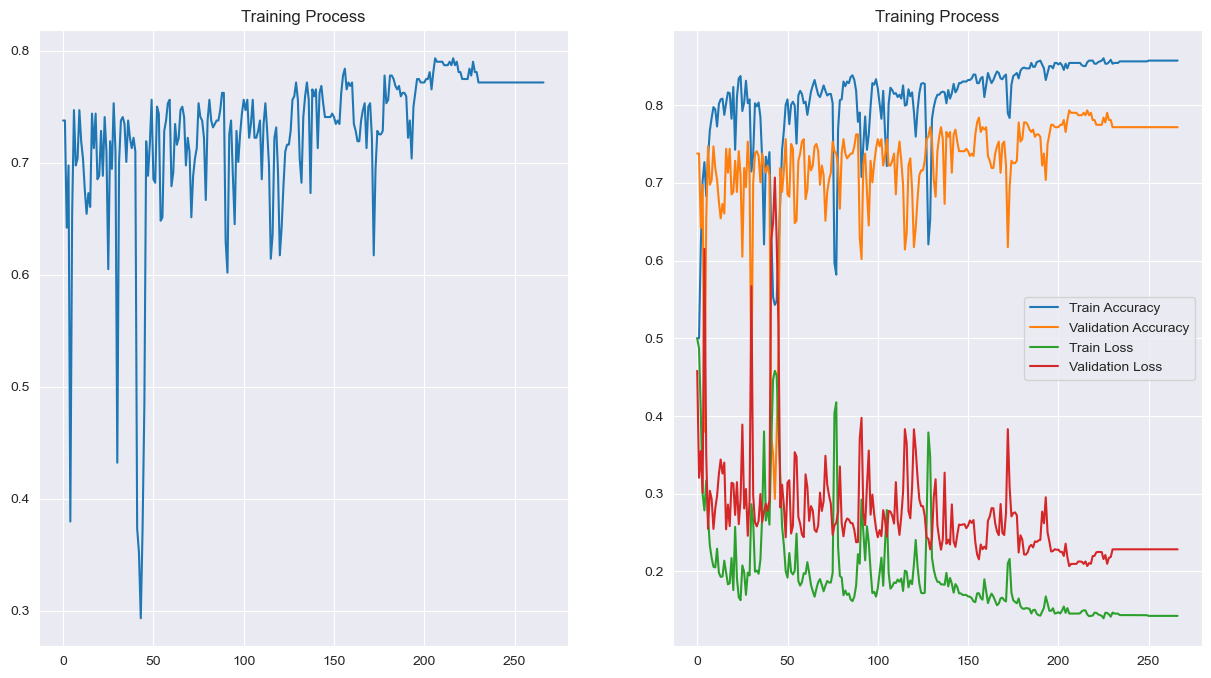

<Figure size 640x480 with 0 Axes>

In [20]:
history=model.history.history
fig,axes=plt.subplots(1,2, figsize=(15,8))
axes[0].plot(pd.DataFrame(history['val_accuracy']))
axes[0].set_title('Training Process')

axes[1].plot(pd.DataFrame(history['accuracy']), label='Train Accuracy')
axes[1].plot(pd.DataFrame(history['val_accuracy']), label='Validation Accuracy')
axes[1].plot(pd.DataFrame(history['loss']), label='Train Loss')
axes[1].plot(pd.DataFrame(history['val_loss']), label='Validation Loss')
axes[1].set_title('Training Process')
axes[1].legend()

plt.show()
plt.savefig('train.png')

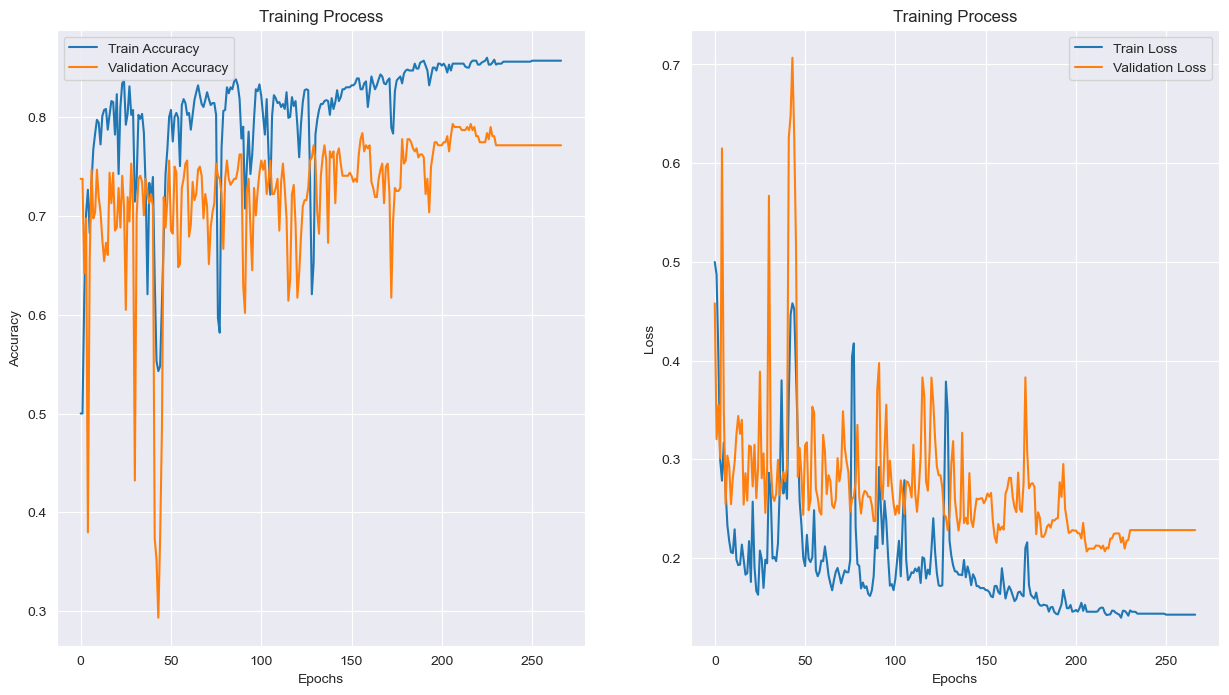

<Figure size 640x480 with 0 Axes>

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Lấy dữ liệu từ history
history = model.history.history

# Vẽ biểu đồ
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Biểu đồ accuracy của tập kiểm tra và tập validation
axes[0].plot(pd.DataFrame(history['accuracy']), label='Train Accuracy')
axes[0].plot(pd.DataFrame(history['val_accuracy']), label='Validation Accuracy')
axes[0].set_title('Training Process')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Biểu đồ loss của tập kiểm tra và tập validation
axes[1].plot(pd.DataFrame(history['loss']), label='Train Loss')
axes[1].plot(pd.DataFrame(history['val_loss']), label='Validation Loss')
axes[1].set_title('Training Process')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Hiển thị biểu đồ
plt.show()

# Lưu biểu đồ vào file
plt.savefig('train.png')


In [22]:
predictions = model.predict(dict_data[data_order][2])
predictions = np.argmax(predictions, axis=1)
accuracy = accuracy_score(y_list[data_order], predictions)
accuracy

11/11 [==============================] - 0s 18ms/step


0.7932098765432098

In [23]:
x_test =dict_data[data_order][2]
y_test=y_list[data_order]

In [24]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Đánh giá độ chính xác
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

# Hiển thị báo cáo phân loại
print("Classification Report:")
print(classification_report(y_test, predictions,labels=[1,0]))

# # Hiển thị ma trận nhầm lẫn
# print("Confusion Matrix:")
# print(confusion_matrix(y_test, y_pred,labels=[1,0]))

Accuracy: 0.7932098765432098
Classification Report:
              precision    recall  f1-score   support

           1       0.59      0.69      0.64        85
           0       0.88      0.83      0.86       239

    accuracy                           0.79       324
   macro avg       0.74      0.76      0.75       324
weighted avg       0.81      0.79      0.80       324



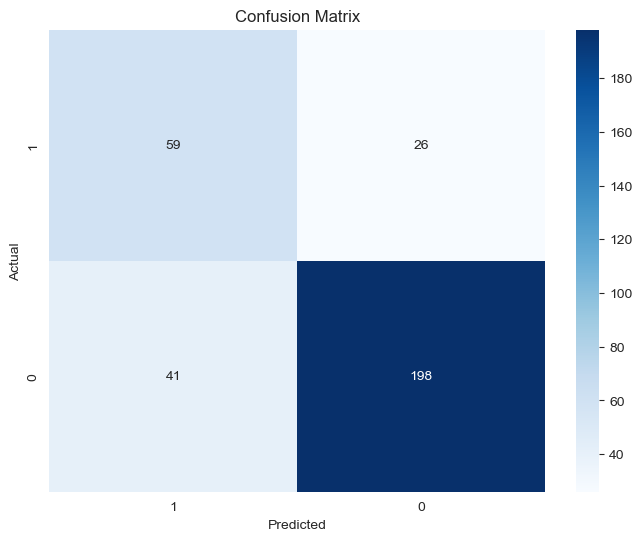

In [25]:
# Tính ma trận nhầm lẫn
cm = confusion_matrix(y_test, predictions,labels=[1,0])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=[1,0], yticklabels=[1,0])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

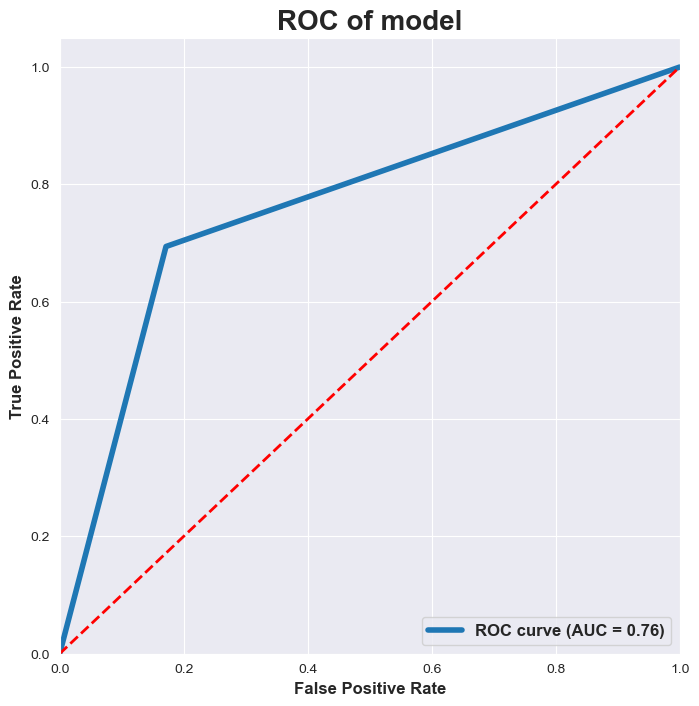

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_test, predictions,ax,name='model'):    
    # Tính toán FPR và TPR từ decision function
    fpr, tpr, _ = roc_curve(y_test, predictions)
    
    # Tính diện tích dưới đường cong ROC (AUC)
    roc_auc = auc(fpr, tpr)

    # Vẽ đường cong ROC
    ax.plot(fpr, tpr, lw=4, label='ROC curve (AUC = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=12, weight='bold')  # Đặt kích thước và độ dày cho nhãn trục x
    ax.set_ylabel('True Positive Rate', fontsize=12, weight='bold')   # Đặt kích thước và độ dày cho nhãn trục y
    ax.set_title(f'ROC of {name}',fontsize=20, weight='bold')  # Đặt kích thước và độ dày cho tiêu đề
    ax.legend(loc="lower right", prop={'size': 12, 'weight': 'bold'})  # Đặt kích thước và độ dày cho chú thích

fig, axes = plt.subplots(1, 1, figsize=(8, 8))

plot_roc_curve(y_test,predictions,axes)
# predictions

In [27]:
def check_result(prediction):
    prediction = (prediction > 0.5).astype(int)
    if isinstance(prediction, (np.ndarray, pd.Series)):
        prediction = prediction.item()  # Hoặc sử dụng prediction[0] hoặc prediction.iloc[0]
    if prediction==1:
        return "Y"
    else:
        return "N"

In [28]:
solandung=0
hopdonggianlan=0
for indx in range(len(x_test)):
    y_predict = predictions
    #print(y_predict[0][0])
    Y_check = check_result(y_test.iloc[indx])
    print('True:', Y_check)
    print('Predicted:', check_result(y_predict[indx]))
    print("----------------------------")
    if Y_check==check_result(y_predict[indx]):
        solandung+=1
        if Y_check=='Y':
            hopdonggianlan+=1
    

True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: Y
----------------------------
True: Y
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: Y
Predicted: Y
----------------------------
True: Y
Predicted: Y
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: Y
Predicted: Y
----------------------------
True: Y
Predicted: Y
----------------------------
True: Y
Predicted: N
----------------------------


In [29]:
print(f"Số lần dự đoán đúng: {solandung} chiếm khoảng {(solandung/len(x_test))*100}% tổng lần dự đoán")
print(f"Số hợp đồng gian lận trong lần kiểm tra: {hopdonggianlan} chiếm khoảng {(hopdonggianlan/len(y_test[y_test['fraud_reported']==1]))*100}% so với thực tế")


Số lần dự đoán đúng: 257 chiếm khoảng 79.32098765432099% tổng lần dự đoán
Số hợp đồng gian lận trong lần kiểm tra: 59 chiếm khoảng 69.41176470588235% so với thực tế
